In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath("..")) # add parent directory for import

## Chapter 4 : Custom Models

In this chapter, we'll cover one of the most important parts of itcsimlib: how to use it to develop and test your own models.

All itcsimlib models must be derived from, or "inherit", either the ITCModel class directly, or a class that is itself a descendent of an ITCModel.

In this example, we will develop a very simple statistical thermodynamics model in which ligands bind to a macromolecule that has five binding sites. The first three binding events will occur with one free energy and enthalpy change, while the binding of the last two ligands to the macromolecule will have a different free energy and enthalpy change. This could mimic either a positively or negatively-cooperative "switch" type behavior, depending on whether the free energy change for the last two binding events is more or less favorable than the first three binding events.

We will use a built-in statistical thermodynamics Ising lattice class available in itcsimlib as the basis for our model. This Ising model primitive already inherits the ITCModel class and we import it like so:

In [2]:
from itcsimlib import *
from itcsimlib.model_ising import Ising

This Ising class is not actually a valid model...yet. The critical element of any statistical thermodynamics model is the assignment of energies to the different potential states the model adopts. The itcsimlib Ising class has already enumerated all possible configurations for us, we just need to set the energies for each by inspecting what sites are occupied/unoccupied.

Our model inherits the Ising class through the following Python convention, and looks at each site in each configuration. If the site has at least one occupied neighbor, it has a different $\Delta G$ and $\Delta H$ than if it has no occupied neighors. By convention, an unoccupied site has $\Delta G = \Delta H = 0$.

Refer to the comments in the model for additional information.

In [3]:
class MyModel(Ising):
    """This is a simple statistical thermodynamics model describing binding to a five-site macromolecule. If a site has at least one occupied (bound) neighbor site, it has a different free energy of binding and change in enthalpy."""
    # itcsimlib automatically converts any ITCModel's class docstring (seen above) into the description for the model. This is not required by itcsimlib, but is a good documentation practice.

    def __init__(self):
        # We use Python's somewhat awkwardly named "__init__" method for initializing the model, and for all itcsimlib models, it must in turn first initialize the parent class it is descended fromt:
        Ising.__init__(self,nsites=5,circular=True)

        # Here, we tell the Ising class the number of sites in our macromolecule, and whether or not the lattice representation of the macromolecule is circular, and from there the Ising class automatically enumerates all possible configurations.
        # In this example, we are not actually using the lattice, but simply the number of ligands already bound to the five-point lattice.

        # Next, we need to register the parameters that our model requires. Because we have two distinct binding affinities and enthalpies, our model will have four parameters. If our model needed to be apply across multiple temperatures, we would also need at least one additional parameter describing the change in heat capacity for the system at each binding process.
        self.add_parameter( 'dG1', type='dG', description='Delta G upon binding to a site with no occupied neighbors.' )
        self.add_parameter( 'dH1', type='dH', description='Delta H upon binding to a site with no occupied neighbors.' )
        self.add_parameter( 'dG2', type='dG', description='Delta G upon binding to a site with 1-2 occupied neighbors.' )
        self.add_parameter( 'dH2', type='dH', description='Delta H upon binding to a site with 1-2 occupied neighbors.' )

        # The ITCModel's add_parameter() method must have at least the parameter's name and type (dG, dH, dCp, etc.) as arguments.
        # As with the model's description, an argument's description is only used when you examine the model's info, as demonstrated in tutorial chapter 1. However, describing your model's parameters is quite useful for future reference by you or others.

        return
    
    def set_energies(self,T0,T):
        # The Ising parent model expects you to define a set_energies() method, that after execution will populate the model's "self.gibbs[]" and "self.enthalpies[]" attributes with the correct energies for each configuration.
        # The Ising model generates several useful class attributes that our set_energies() method can use. For our five-site lattice, there are 2^5 or 32 potentially energetically-distinct configurations of ligands bound to the lattice. This number of configs is determined by the Ising class during initialization and stored in the "self.nconfigs" attribute.
        
        for i in range(self.nconfigs): # Iterate over all potential Lattice + Ligand(s) configurations.
            self.gibbs[i], self.enthalpies[i] = 0.0, 0.0 # Reset configuration dG and dH.
            self.config_expressions[i] = 0 # Reset symbolic expression for the configuration
            
            for j in range(self.nsites): # Iterate over each site in every configuration.
            
                if not self.get_site_occupancy(i, j):
                    pass # If the site's not occupied, by convention we have dG and dH == 0.
                
                # Are either of the neighboring sites occupied?
                elif self.get_site_occupancy(i, j+1) or self.get_site_occupancy(i, j-1):
                    self.gibbs[i] += self.params['dG2']
                    self.enthalpies[i] += self.params['dH2']
                    self.config_expressions[i] += self.parameter_symbols['dG2']
                
                else: # Neither neighboring site contains a ligand.
                    self.gibbs[i] += self.params['dG1']
                    self.enthalpies[i] += self.params['dH1']
                    self.config_expressions[i] += self.parameter_symbols['dG1']
                                                
        return

That's it! The remaining built-in Ising model class methods will take care of everything else.

Assign the simulator to use our custom model:

In [4]:
sim = ITCSim(T0=298.15,units="kcal",verbose=True)

sim.add_experiment_synthetic(
    T=298.15,
    V0=1416.6,
    injections=[5.0]*50,
    Cell={"Lattice":1E-6},
    Syringe={"Ligand":50E-6},
    noise=0.0,
    title='MyModel_Test')

sim.set_model( MyModel() )

Print the full information for our model, just for fun:

In [5]:
print(sim.model)


Model: __main__.MyModel

Description:
This is a simple statistical thermodynamics model describing binding to a five-site macromolecule. If a site has at least one occupied (bound) neighbor site, it has a different free energy of binding and change in enthalpy.

Components:
Index	Name	Description
1)	Lattice	A circular lattice with 5 binding sites
2)	Ligand	A lattice-binding ligand

Parameters:
Index	Param     Type                Value               Description
1)	dG1       Free energy         0.000 kcal/mol      Delta G upon binding to a site with no occupied neighbors.
2)	dH1       Enthalpy            0.000 kcal/mol      Delta H upon binding to a site with no occupied neighbors.
3)	dG2       Free energy         0.000 kcal/mol      Delta G upon binding to a site with 1-2 occupied neighbors.
4)	dH2       Enthalpy            0.000 kcal/mol      Delta H upon binding to a site with 1-2 occupied neighbors.



Set the values for the parameters we defined in the model. Let's first model positive cooperativity by making binding to a site with an already-occupied neighbor possess a greater negative $\Delta G$:

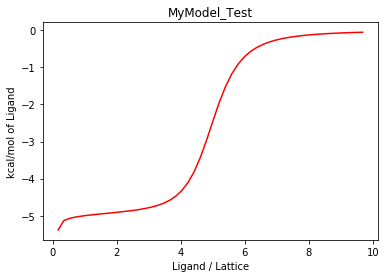

In [6]:
sim.set_model_params(dG1=-8, dH1=-10, dG2=-10, dH2=-5)

sim.run()

sim.make_plots()

Similarily, we can easily model negative cooperativity by making binding to a site with one or more unoccupied neighbor sites possess a more unfavorable $\Delta G$, and compare the titration curves for our model when it's exhibiting positive vs. negative cooperativity:

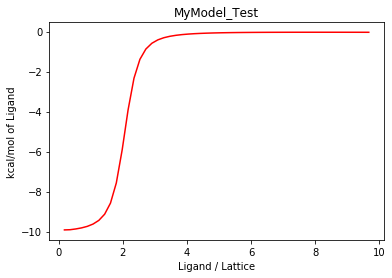

In [7]:
sim.set_model_params(dG1=-10, dH1=-10, dG2=-8, dH2=-5)

sim.run()

sim.make_plots()

The primary purpose of itcsimlib was to leverage the power of Ising-based models. To help you, the researcher, develop and understand such models, the Ising model base class provides a couple of potentially very useful tools.

One of which is the ability to generate the grand partition function for the model (this is constructed from all those `self.config_expressions` terms entered in the model's `set_energies()` method:

In [8]:
sim.model.get_partition_function()

5*K_dG1*L + K_dG2**5*L**5 + 5*K_dG2**4*L**4 + 5*K_dG2**2*L**3*(K_dG1 + K_dG2) + 5*L**2*(K_dG1**2 + K_dG2**2) + 1

We can also generate potentially illuminating diagrams of the different lattice + ligand configurations at the current values of the model parameters:

In [9]:
display( sim.model.draw_lattices(size=2.0, dG_format="%i") )

All finished. In the next chapter, we'll look at how you can get a better handle on your model by changing parameters in real-time and seeing the effects.

In [10]:
sim.done()